# Reduce Footprints of Multiport Interferometers by CSD
![](https://shields.io/badge/conference-OFC'22-blue)
- **Date:** Dec 6, 2021
- **Author:** Yinyi LIU
- **Version:** 0.1.0
- **Abstract:** We present a novel 3D-unfolding method based on Cosine-Sine-Decomposition (CSD) to enable an alternative arrangement of unitary blocks towards plane normal, which reduces the planar footprints of universal multiport interferometers exponentially.

In [1]:
import scipy
import numpy as np
from scipy.linalg import cossin
from scipy.stats import unitary_group
from matplotlib import pyplot as plt

## Preliminary
Cosine-Sine Decomposition

$	
\begin{bmatrix}
    U_1^T & 0 \\
    0 & U_2^T
\end{bmatrix}
\begin{bmatrix}
    M_{1,1} & M_{1,2} \\
    M_{2,1} & M_{2,2}
\end{bmatrix}
\begin{bmatrix}
    V_1 & 0 \\
    0 & V_2
\end{bmatrix}
= 
\begin{bmatrix}
    C & -S & 0 \\
    S & C & 0 \\
    0 & 0 & I_{n-2p} \\
\end{bmatrix}
$

### Generate Unitary Matrices

In [2]:
# Random Arbitrary Matrix
mat = np.random.randn(4, 5)

# Singular Value Decomposition
[u, s, v] = np.linalg.svd(mat)

### CS-Decompose the Unitary Matrix

$
U_u = 
\begin{bmatrix}
   U_1 & 0 \\
   0 & U_2
\end{bmatrix}
$

$
\Theta_{cs} = 
\begin{bmatrix}
   cos(\theta) & -sin(\theta) \\
   sin(\theta) & cos(\theta)
\end{bmatrix}
$

$
V^H = 
\begin{bmatrix}
   V_1^H & 0 \\
   0 & V_2^H
\end{bmatrix}
$

In [3]:
# Separate Output
(u1, u2), theta, (v1h, v2h) = cossin(u, p=2, q=2, separate=True)

# Unified Output
[uu, cs, vh] = cossin(u, p=2, q=2)

#### Unit Test: Separated vs Combined

In [4]:
# Verification
b11 = u1 @ np.diag(np.cos(theta)) @ v1h
b12 = u1 @ np.diag(-np.sin(theta)) @ v2h
b21 = u2 @ np.diag(np.sin(theta)) @ v1h
b22 = u2 @ np.diag(np.cos(theta)) @ v2h

assert np.allclose(u[:2, :2], b11)
assert np.allclose(u[:2, 2:], b12)
assert np.allclose(u[2:, :2], b21)
assert np.allclose(u[2:, 2:], b22)

#### Unit Test: Column-Merged Form

In [5]:
# Output All
vec = np.random.randn(4, 1)
out = u @ vec

# Output Port [0-1]
out1 = np.concatenate(
        (u1 @ np.diag(np.cos(theta)) @ v1h,
        u1 @ np.diag(-np.sin(theta)) @ v2h),
    axis=1) @ vec

# Output Port [2-3]
out2 = np.concatenate(
        (u2 @ np.diag(np.sin(theta)) @ v1h,
        u2 @ np.diag(np.cos(theta)) @ v2h),
    axis=1) @ vec

assert np.allclose(out[:2], out1)
assert np.allclose(out[2:], out2)

#### Unit Test: Successive-Reconstruction Form

In [6]:
# Propagate along V^H (horizontal)
v1h_out = v1h @ vec[:2]
v2h_out = v2h @ vec[2:]

# Rearrange Input Vectors for CS
cs1_in = np.concatenate((v1h_out[0], v2h_out[0])).reshape(2, 1)
cs2_in = np.concatenate((v1h_out[1], v2h_out[1])).reshape(2, 1)

# Recover CS Transfer Matrices 
cs1 = np.array([
    [np.cos(theta[0]), -np.sin(theta[0])],
    [np.sin(theta[0]), np.cos(theta[0])]
])
cs2 = np.array([
    [np.cos(theta[1]), -np.sin(theta[1])],
    [np.sin(theta[1]), np.cos(theta[1])]
])

# Propagate along CS (vertical)
cs1_out = cs1 @ cs1_in
cs2_out = cs2 @ cs2_in

# Rearrange Input Vectors for U
uu1_in = np.concatenate((cs1_out[0], cs2_out[0])).reshape(2, 1)
uu2_in = np.concatenate((cs1_out[1], cs2_out[1])).reshape(2, 1)

# Propagate along U (horizontal)
uu1_out = u1 @ uu1_in
uu2_out = u2 @ uu2_in

assert np.allclose(out1, uu1_out)
assert np.allclose(out2, uu2_out)

## Planar Decomposition Methods
- [x] Reck's $^{[1]}$
- [x] Clements' $^{[2]}$

**References**    
[1] Reck, Michael, et al. "Experimental realization of any discrete unitary operator." Physical review letters 73.1 (1994): 58.    
[2] Clements, William R., et al. "Optimal design for universal multiport interferometers." Optica 3.12 (2016): 1460-1465.

### Helper Functions

In [7]:
def atan2f(y, x, tolerance=1e-6, to_degree=False):
    zero_y = np.abs(y) <= tolerance
    zero_x = np.abs(x) <= tolerance
    if zero_x and zero_y:
        rad = 0
    elif zero_x and (not zero_y):
        rad = np.pi/2 if y > tolerance else -np.pi/2
    elif (not zero_x) and zero_y:
        rad = 0 if x > tolerance else np.pi
    else:
        rad = np.arctan2(y, x)
    if to_degree:
        return np.rad2deg(rad)
    else:
        return rad
    

def angle_diff(comp_src, comp_dst, offset=0, tolerance=1e-6, wrap=True, to_degree=False):
    zero_src = np.abs(comp_src) <= tolerance
    zero_dst = np.abs(comp_dst) <= tolerance
    if zero_src and zero_dst:
        rad = 0
    elif zero_src and (not zero_dst):
        rad = np.angle(comp_dst)
    elif (not zero_src) and zero_dst:
        rad = -np.angle(comp_src)
    else:
        rad = np.angle(comp_dst) - np.angle(comp_src)
    rad += offset
    if wrap:
        rad = np.mod(rad, 2 * np.pi)
    if to_degree:
        return np.rad2deg(rad)
    else:
        return rad

### Types of Unitary Blocks
- [x] Beam Splitter
- [x] Mach Zehnder Interferometer

In [11]:
def U2BS(dim, m, n, phi, theta, use_sym=False, Lp=1, Lc=1):
    assert m < n < dim
    if use_sym:
        mat = sp.eye(dim)
        mat[m, m] = sp.sqrt(Lp) * sp.exp(sp.I * phi) * sp.cos(theta)
        mat[m, n] = sp.sqrt(Lc) * sp.I * sp.sin(theta)
        mat[n, m] = sp.sqrt(Lc) * sp.I * sp.exp(sp.I * phi) * sp.sin(theta)
        mat[n, n] = sp.sqrt(Lp) * sp.cos(theta)
    else:
        mat = np.eye(dim, dtype=np.complex128)
        mat[m, m] = np.sqrt(Lp) * np.exp(1j * phi) * np.cos(theta)
        mat[m, n] = np.sqrt(Lc) * 1j * np.sin(theta)
        mat[n, m] = np.sqrt(Lc) * 1j * np.exp(1j * phi) * np.sin(theta)
        mat[n, n] = np.sqrt(Lp) * np.cos(theta)
    return mat


def U2MZI(dim, m, n, phi, theta, use_sym=False, Lp=1, Lc=1):
    assert m < n < dim
    if use_sym:
        mat = sp.eye(dim)
        mat[m, m] = sp.sqrt(Lp) * sp.I * sp.exp(sp.I * phi) * sp.sin(theta)
        mat[m, n] = sp.sqrt(Lc) * sp.I * sp.cos(theta)
        mat[n, m] = sp.sqrt(Lc) * sp.I * sp.exp(sp.I * phi) * sp.cos(theta)
        mat[n, n] = -sp.sqrt(Lp) * sp.I * sp.sin(theta)
    else:
        mat = np.eye(dim, dtype=np.complex128)
        mat[m, m] = np.sqrt(Lp) * 1j * np.exp(1j * phi) * np.sin(theta)
        mat[m, n] = np.sqrt(Lc) * 1j * np.cos(theta)
        mat[n, m] = np.sqrt(Lc) * 1j * np.exp(1j * phi) * np.cos(theta)
        mat[n, n] = -np.sqrt(Lp) * 1j * np.sin(theta)
    return mat

### Reck's Method

In [12]:
def decompose_reck(u, block='bs'):
    assert isinstance(u, np.ndarray)
    assert isinstance(block, str) and block.strip().lower() in ['bs', 'mzi']
    if len(u.shape) != 2:
        raise ValueError("U(N) should be 2-dimension matrix.")
        
    if u.shape[0] != u.shape[1]:
        raise ValueError("U(N) should be a square matrix.")
        
    mat = u.copy().astype(np.complex128)
    dim = mat.shape[0]
    num = int(dim * (dim - 1) / 2)
    phis = np.zeros(num)
    thetas = np.zeros(num)
    alphas = np.zeros(dim)
    index = 0
    for p in range(1, dim):
        x = dim - p
        for q in range(dim-p, 0, -1):
            y = q - 1
            if block == 'bs':
                thetas[index] = atan2f(np.abs(mat[x,y]), np.abs(mat[x,x]))
                phis[index] = angle_diff(mat[x,x], mat[x,y], offset=-np.pi/2)
                U2block = U2BS
            elif block == 'mzi':
                thetas[index] = np.pi/2 - atan2f(np.abs(mat[x,y]), np.abs(mat[x,x]))
                phis[index] = angle_diff(mat[x,x], mat[x,y], offset=np.pi)
                U2block = U2MZI
            mat = mat @ U2block(dim, y, x, phis[index], thetas[index]).conj().T
            index += 1
    for i in range(dim):
        alphas[i] = np.angle(mat[i, i])
    return phis, thetas, alphas


def reconstruct_reck(phis, thetas, alphas, block='bs', Lp_dB=0, Lc_dB=0):
    assert len(phis.squeeze().shape) == 1
    assert len(thetas.squeeze().shape) == 1
    assert len(alphas.squeeze().shape) == 1
    assert phis.squeeze().shape[0] == thetas.squeeze().shape[0]
    assert isinstance(block, str) and block.strip().lower() in ['bs', 'mzi']
    if block == 'bs':
        U2block = U2BS
    elif block == 'mzi':
        U2block = U2MZI
    
    num = thetas.squeeze().shape[0]
    dim = int((1 + np.sqrt(1 + 8 * num))/ 2)
    assert alphas.squeeze().shape[0] == dim
    
    Lp = 10 ** (Lp_dB / 10)
    Lc = 10 ** (Lc_dB / 10)
    
    mat = np.diag(np.exp(1j * alphas))
    index = num
    for p in range(1, dim):
        for q in range(p):
            index -= 1
            mat = mat @ U2block(dim, q, p, phis[index], thetas[index], Lp=Lp, Lc=Lc)
    return mat

### Clements' Method

In [26]:
def decompose_clements(u, block='bs'):
    assert isinstance(u, np.ndarray)
    assert isinstance(block, str) and block.strip().lower() in ['bs', 'mzi']
    if len(u.shape) != 2:
        raise ValueError("U(N) should be 2-dimension matrix.")
        
    if u.shape[0] != u.shape[1]:
        raise ValueError("U(N) should be a square matrix.")
        
    mat = u.copy().astype(np.complex128)
    dim = mat.shape[0]
    
    row = dim - 1
    col = int(np.ceil(dim / 2))
    
    cnt_fore = np.zeros(row, dtype=int)
    cnt_back = np.ones(row, dtype=int) * (col - 1)
    if dim % 2 == 1:
        cnt_back[1::2] = col - 2
    
    phis = np.zeros((row, col))
    thetas = np.zeros((row, col))
    alphas = np.zeros(dim)
    
    for p in range(dim-1):
        for q in range(p+1):
            if p % 2 == 0:
                x = dim - 1 - q
                y = p - q
                if block == 'bs':
                    theta = atan2f(np.abs(mat[x,y]), np.abs(mat[x,y+1]))
                    phi = angle_diff(mat[x,y+1], mat[x,y], offset=-np.pi/2)
                    U2block = U2BS
                elif block == 'mzi':
                    theta = np.pi/2 - atan2f(np.abs(mat[x,y]), np.abs(mat[x,y+1]))
                    phi = angle_diff(mat[x,y+1], mat[x,y], offset=np.pi)
                    U2block = U2MZI
                mat = mat @ U2block(dim, y, y+1, phi, theta).conj().T
                thetas[y, cnt_fore[y]] = theta
                phis[y, cnt_fore[y]] = phi
                cnt_fore[y] += 1
            else:
                x = dim - 1 - p + q
                y = q
                if block == 'bs':
                    theta = atan2f(np.abs(mat[x,y]), np.abs(mat[x-1,y]))
                    phi = angle_diff(mat[x-1,y], mat[x,y], offset=np.pi/2)
                    U2block = U2BS
                elif block == 'mzi':
                    theta = np.pi/2 - atan2f(np.abs(mat[x,y]), np.abs(mat[x-1,y]))
                    phi = angle_diff(mat[x-1,y], mat[x,y], offset=0)
                    U2block = U2MZI
                mat = U2block(dim, x-1, x, phi, theta) @ mat
                thetas[x-1, cnt_back[x-1]] = theta
                phis[x-1, cnt_back[x-1]] = phi
                cnt_back[x-1] -= 1
    for p in range(dim-2, -1, -1):
        for q in range(p, -1, -1):
            if p % 2 == 0:
                continue
            x = dim - 1 - p + q
            y = q
            cnt_back[x-1] += 1
            theta = thetas[x-1, cnt_back[x-1]]
            phi = phis[x-1, cnt_back[x-1]]
            eta1 = mat[x-1, x-1]
            eta2 = mat[x, x]
            if block == 'bs':
                phi_new = angle_diff(eta2, -eta1, offset=0)
                mat[x-1, x-1] = eta1 * np.exp(-1j * (phi+phi_new))
            elif block == 'mzi':
                phi_new = angle_diff(eta2, eta1, offset=0)
                mat[x-1, x-1] = -eta1 * np.exp(-1j * (phi+phi_new))
                mat[x, x] = -eta2
            phis[x-1, cnt_back[x-1]] = phi_new
    for i in range(dim):
        alphas[i] = np.angle(mat[i, i])
    return phis, thetas, alphas


def reconstruct_clements(phis, thetas, alphas, block='bs', Lp_dB=0, Lc_dB=0):
    assert len(phis.squeeze().shape) == 2 or phis.size == 1
    assert len(thetas.squeeze().shape) == 2 or thetas.size == 1
    assert len(alphas.squeeze().shape) == 1
    assert phis.squeeze().shape == thetas.squeeze().shape
    assert isinstance(block, str) and block.strip().lower() in ['bs', 'mzi']
    
    if block == 'bs':
        U2block = U2BS
    elif block == 'mzi':
        U2block = U2MZI
    
    if thetas.size == 1:
        row = 1
        col = 1
    else:
        row, col = thetas.squeeze().shape
    dim = row + 1
    num = int(dim * (dim - 1) / 2) 
    assert alphas.squeeze().shape[0] == dim
    
    Lp = 10 ** (Lp_dB / 10)
    Lc = 10 ** (Lc_dB / 10)
    
    sft = np.diag(np.exp(1j * alphas))
    mat = np.eye(dim)
    for p in range(col):
        for q in range(0, row, 2):
            mat = U2block(dim, q, q+1, phis[q,p], thetas[q,p], Lp=Lp, Lc=Lc) @ mat
        if p >= col - 1 and dim % 2 == 1:
            continue
        for q in range(1, row, 2):
            mat = U2block(dim, q, q+1, phis[q,p], thetas[q,p], Lp=Lp, Lc=Lc) @ mat
    mat = sft @ mat
    return mat

### Unit Test

In [27]:
# Parameter To Test
BOUND = 100
MAT_ROW = 40
MAT_COL = 50
print('==== Unit Test ====')

# Singular Value Decomposition
mat = np.random.randint(-np.abs(BOUND), np.abs(BOUND), (MAT_ROW, MAT_COL))
[u, s, v] = np.linalg.svd(mat, full_matrices=True)

# Recovery from SVD
print(f'Recovery from SVD:\t {np.allclose(mat, u[:, :MAT_COL] @ np.diag(s) @ v[:MAT_ROW, :])}')

# Reck BS
[p, t, a] = decompose_reck(u, block='bs')
reck_test = reconstruct_reck(p, t, a, block='bs')
print(f'Reck[BS] Test:\t\t {np.allclose(reck_test, u)}')

# Reck MZI
[p, t, a] = decompose_reck(u, block='mzi')
reck_test = reconstruct_reck(p, t, a, block='mzi')
print(f'Reck[MZI] Test:\t\t {np.allclose(reck_test, u)}')

# Clements BS
[p, t, a] = decompose_clements(u, block='bs')
clements_test = reconstruct_clements(p, t, a, block='bs')
print(f'Clements[BS] Test:\t {np.allclose(clements_test, u)}')

# Clements MZI
[p, t, a] = decompose_clements(u, block='mzi')
clements_test = reconstruct_clements(p, t, a, block='mzi')
print(f'Clements[MZI] Test:\t {np.allclose(clements_test, u)}')

==== Unit Test ====
Recovery from SVD:	 True
Reck[BS] Test:		 True
Reck[MZI] Test:		 True
Clements[BS] Test:	 True
Clements[MZI] Test:	 True


## CSD Unfolding Library for Universal Multiport Interferometers (UMI)

API is shown as follows:

```python
class UmiCsd:
    def decompose(matrix, p=None, q=None) -> None
    def decompose_recursive(depth) -> None
    def reconstruct(Lp_dB=0, Lc_dB=0, method='clements', block='bs') -> numpy.ndarray
```

In [92]:
class UmiCsd:
    def __init__(self, matrix=None, p=None, q=None):
        self.u1 = None
        self.u2 = None
        self.theta = None
        self.v1h = None
        self.v2h = None
        self.matrix = None
        
        if matrix is not None:
            self.decompose(matrix, p, q)
    
    def __repr__(self):
        return "{}".format(self.matrix)
    
    def form_cs(self, Lp_dB=0, Lc_dB=0, swap_sign=False):
        cs = []
        Lp = 10 ** (Lp_dB / 10)
        Lc = 10 ** (Lc_dB / 10)
        for t in self.theta:
            tmp = np.array([
                [np.sqrt(Lp) * np.cos(t), -np.sqrt(Lc) * np.sin(t)],
                [np.sqrt(Lc) * np.sin(t), np.sqrt(Lp) * np.cos(t)]
            ])
            tmp = tmp.T if swap_sign else tmp
            cs.append(tmp)
        return cs
    
    @staticmethod
    def rearrange_vector(vec1, vec2):
        assert len(vec1) == len(vec2)
        assert len(vec1) == vec1.size
        assert len(vec2) == vec2.size
        
        N = len(vec1)
        retval = []
        for i in range(N):
            tmp = np.concatenate((vec1[i], vec2[i])).reshape(2, 1)
            retval.append(tmp)
            
        return retval
    
    def decompose(self, matrix, p=None, q=None):
        assert matrix.ndim == 2, "[ERROR] Dimension of Input Matrix is NOT 2."
        assert np.allclose(matrix @ matrix.conj().T, np.eye(len(matrix))), "[ERROR] Input Matrix is NOT Unitary."
        
        if p is None and q is None:
            p = len(matrix) // 2
            q = len(matrix) - p
        elif p is None:
            p = len(matrix) - q
        elif q is None:
            q = len(matrix) - p
            
        self.matrix = matrix
        (self.u1, self.u2), self.theta, (self.v1h, self.v2h) = cossin(matrix, p=p, q=q, separate=True)
    
    def decompose_recursive(self, depth):
        def check_and_csd(mat, d):
            if isinstance(mat, np.ndarray):
                if len(mat) <= 2:
                    return mat
                if d > 0:
                    ret = UmiCsd(mat)
                    ret.decompose_recursive(d-1)
                    return ret
                else:
                    return UmiCsd(mat)
            elif isinstance(mat, UmiCsd):
                return mat
            else:
                raise "[ERROR] Not Supported Type in func<decompose_recursive>."
        
        self.u1 = check_and_csd(self.u1, depth-1)
        self.u2 = check_and_csd(self.u2, depth-1)
        self.v1h = check_and_csd(self.v1h, depth-1)
        self.v2h = check_and_csd(self.v2h, depth-1)
        
    def reconstruct(self, Lp_dB=0, Lc_dB=0, method='clements', block='bs'):
        assert method.lower() in ['reck', 'clements']
        assert block.lower() in ['bs', 'mzi']
        if method.lower() == 'reck':
            planar_decompose = decompose_reck
            planar_reconstruct = reconstruct_reck
        elif method.lower() == 'clements':
            planar_decompose = decompose_clements
            planar_reconstruct = reconstruct_clements
        
        def check_and_rcs(mat):
            if isinstance(mat, np.ndarray):
                if len(mat) < 2:
                    return mat
                [p, t, a] = planar_decompose(mat, block=block.lower())
                return planar_reconstruct(p, t, a, block=block.lower(), Lp_dB=Lp_dB, Lc_dB=Lc_dB)
            elif isinstance(mat, UmiCsd):
                return mat.reconstruct(Lp_dB=Lp_dB, Lc_dB=Lc_dB, method=method, block=block)
            else:
                raise "[Error] Not Supported Type in func<reconstruct>."
                
        _u1 = check_and_rcs(self.u1)
        _u2 = check_and_rcs(self.u2)
        _v1h = check_and_rcs(self.v1h)
        _v2h = check_and_rcs(self.v2h)
        
        Lp = 10 ** (Lp_dB / 10)
        Lc = 10 ** (Lc_dB / 10)
        
        def bridge_matrix(factor, value, cs, m1, m2):
            assert cs in ['sin', 'cos']
            if cs == 'sin':
                ops = np.sin
            elif cs == 'cos':
                ops = np.cos
            
            m = np.eye(m1.shape[1] if m1.shape[1] >= m2.shape[0] else m2.shape[0])
            l = len(value)
            m[:l, :l] = factor * np.diag(ops(value))
            return m[:m1.shape[1], :m2.shape[0]]
        
        _cs11 = bridge_matrix(np.sqrt(Lp), self.theta, 'cos', _u1, _v1h)
        _cs12 = bridge_matrix(np.sqrt(Lc), -self.theta, 'sin', _u1, _v2h)
        _cs21 = bridge_matrix(np.sqrt(Lc), self.theta, 'sin', _u2, _v1h)
        _cs22 = bridge_matrix(np.sqrt(Lp), self.theta, 'cos', _u2, _v2h)
        
        _b11 = _u1 @ _cs11 @ _v1h
        _b12 = _u1 @ _cs12 @ _v2h
        _b21 = _u2 @ _cs21 @ _v1h
        _b22 = _u2 @ _cs22 @ _v2h
            
        return np.block([[_b11, _b12], [_b21, _b22]])  

### Unit Test

In [99]:
import random

DEPTH_MIN = 0
DEPTH_MAX = 20

for i in range(3, 101):
    test_unitary = unitary_group.rvs(i)

    umi = UmiCsd(test_unitary)
    umi.decompose_recursive(depth=random.randint(DEPTH_MIN, DEPTH_MAX))
    assert np.allclose(test_unitary, umi.reconstruct(block='bs')), "[FAIL] UmiCsd fails Unit Test in block='bs'."
    assert np.allclose(test_unitary, umi.reconstruct(block='mzi')), "[FAIL] UmiCsd fails Unit Test in block='mzi'."

print("[PASS] UmiCsd passes Unit Test.")

[PASS] UmiCsd passes Unit Test.


## Fidelity Comparison

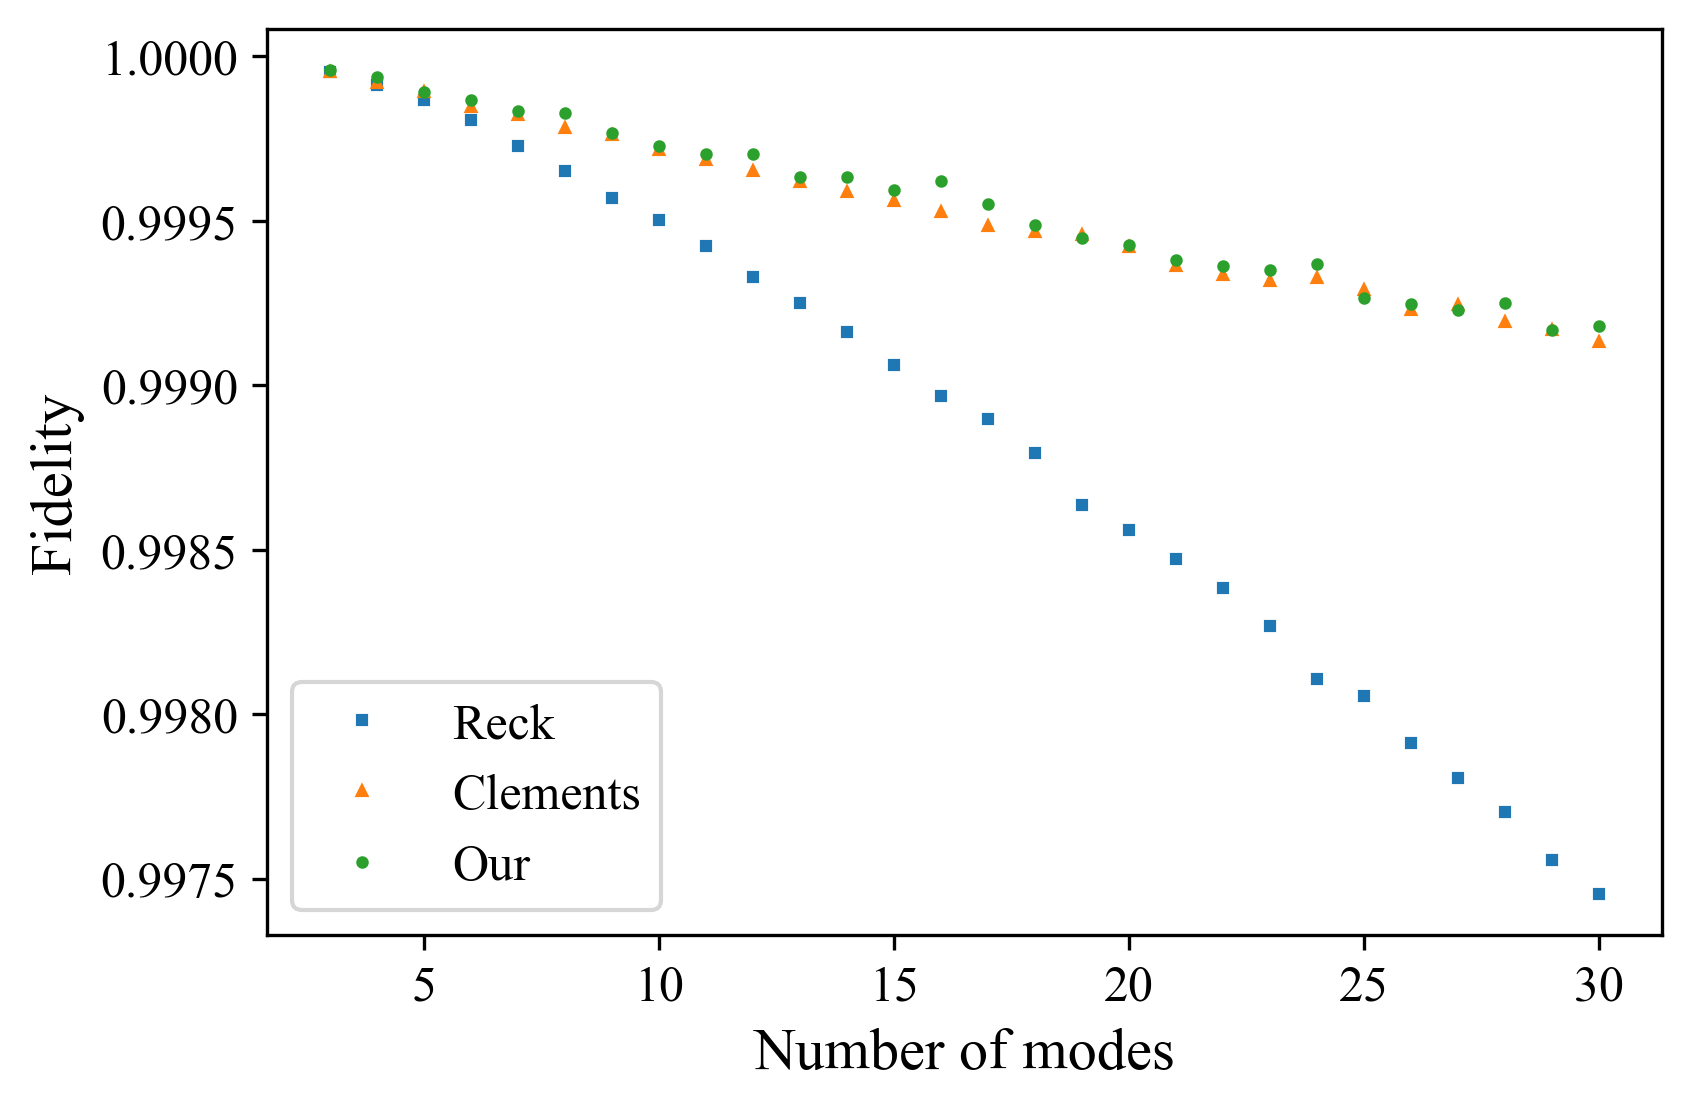

In [102]:
# System Configurations and Parameters
NUM_MODE = 31
Lp_dB = -0.01
Lc_dB = -0.1
COUNT = 100 #Setting 100 will Need 1.89 Hours to run

# Buffers to store the data for drawings
fidelity = np.zeros((NUM_MODE, 1))

# Setup for Matplotlib
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "normal"
plt.rcParams["font.size"] = 12
plt.figure(dpi=300)
x = range(3, NUM_MODE)

# Sweep Parameters [Reck]
for i in range(3, NUM_MODE):
    statistic = 0.0
    for _ in range(COUNT):
        mat = np.random.randn(i, i)
        [u, s, v] = np.linalg.svd(mat, full_matrices=True)
        [p, t, a] = decompose_reck(u, block='mzi')
        Ue = reconstruct_reck(p, t, a, block='mzi', Lp_dB=Lp_dB, Lc_dB=Lc_dB)
        statistic += np.abs(np.trace(u.conj().T @ Ue) / np.sqrt(i * np.trace(Ue.conj().T @ Ue))) ** 2
    fidelity[i] = statistic / COUNT

# Annotate Setup
y_reck = fidelity[3:NUM_MODE].copy()
plt.plot(x, y_reck, 's', markersize=2)

# Sweep Parameters [Clements]
for i in range(3, NUM_MODE):
    statistic = 0.0
    for _ in range(COUNT):
        mat = np.random.randn(i, i)
        [u, s, v] = np.linalg.svd(mat, full_matrices=True)
        [p, t, a] = decompose_clements(u, block='mzi')
        Ue = reconstruct_clements(p, t, a, block='mzi', Lp_dB=Lp_dB, Lc_dB=Lc_dB)
        statistic += np.abs(np.trace(u.conj().T @ Ue) / np.sqrt(i * np.trace(Ue.conj().T @ Ue))) ** 2
    fidelity[i] = statistic / COUNT

# Annotate Setup
y_clements = fidelity[3:NUM_MODE].copy()
plt.plot(x, y_clements, '^', markersize=2)

# Sweep Parameters [Our]
for i in range(3, NUM_MODE):
    statistic = 0.0
    for _ in range(COUNT):
        mat = np.random.randn(i, i)
        [u, s, v] = np.linalg.svd(mat, full_matrices=True)
        umi = UmiCsd(u)
        umi.decompose_recursive(depth=i)
        Ue = umi.reconstruct(block='mzi', Lp_dB=Lp_dB, Lc_dB=Lc_dB)
        statistic += np.abs(np.trace(u.conj().T @ Ue) / np.sqrt(i * np.trace(Ue.conj().T @ Ue))) ** 2
    fidelity[i] = statistic / COUNT

# Annotate Setup
y_our = fidelity[3:NUM_MODE].copy()
plt.plot(x, y_our, 'o', markersize=2)

# Decorate Figures
plt.xlabel('Number of modes', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)
plt.legend(['Reck', 'Clements', 'Our'])

plt.show()